In [1]:
from defense import Switch, plot_defense

In [2]:
scheme = [
    Switch('ШР', [('overload_csv', 'ВА-99 1000А.xlsx'), ('independent', (8000, 0.01))]),
    Switch('КТП-0,4-секц', [('overload', (1440, 15)), ('independent', (1900, 0.1)), ('independent', (13750, 0.01))]),
    Switch('КТП-0,4', [('overload', (1730, 15)), ('independent',(2300, 0.2)), ('independent', (16500, 0.01))]),
    Switch('Проект. КТП', [('independent', (183*15, 0.3)), ('independent', (1614*15, 0.01))]),
    Switch('РП-12 Байсад Л-2', [('independent', (220*15, 0.5)), ('independent', (5192*15, 0.01))])
]

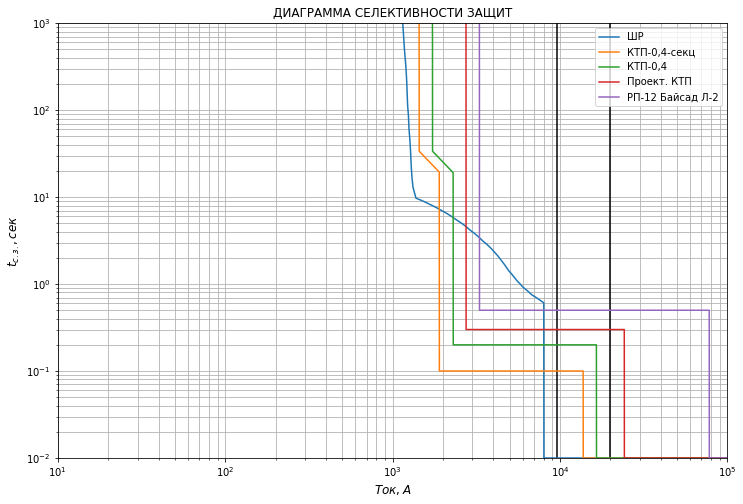

In [3]:
plot_defense(scheme, )